In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch_geometric

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

#!pip3 install torch_geometric
#!pip3 install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())


Processing...
Done!


In [ ]:
class GCNModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(num_features, 64)
        self.conv2 = torch_geometric.nn.GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(dataset.num_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    return correct / data.test_mask.sum().item()


In [ ]:
epochs = 10

for epoch in range(epochs):
    loss = train()
    test_acc = test()
    print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.3680, Test Acc: 0.8130
Epoch: 002, Loss: 0.3645, Test Acc: 0.8160
Epoch: 003, Loss: 0.3340, Test Acc: 0.8140
Epoch: 004, Loss: 0.3521, Test Acc: 0.8190
Epoch: 005, Loss: 0.3440, Test Acc: 0.8170
Epoch: 006, Loss: 0.3431, Test Acc: 0.8180
Epoch: 007, Loss: 0.3392, Test Acc: 0.8170
Epoch: 008, Loss: 0.3402, Test Acc: 0.8150
Epoch: 009, Loss: 0.3246, Test Acc: 0.8170
Epoch: 010, Loss: 0.3393, Test Acc: 0.8160


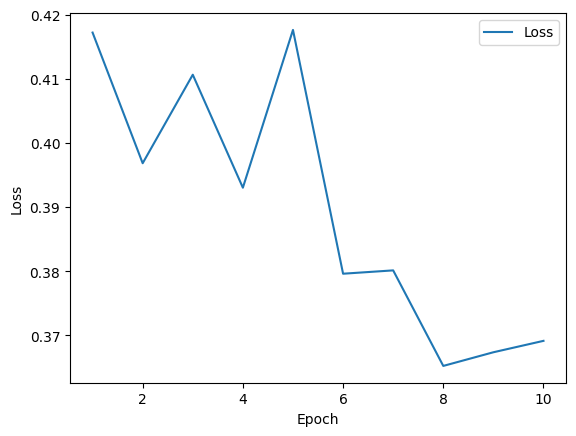

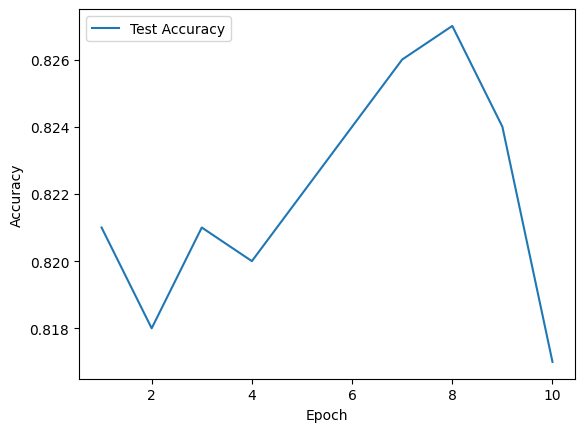

In [ ]:
loss_history = []
test_acc_history = []

epochs = 10

for epoch in range(epochs):
    loss = train()
    test_acc = test()
    loss_history.append(loss)
    test_acc_history.append(test_acc)

plt.figure()
plt.plot(range(1, epochs + 1), loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, epochs + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


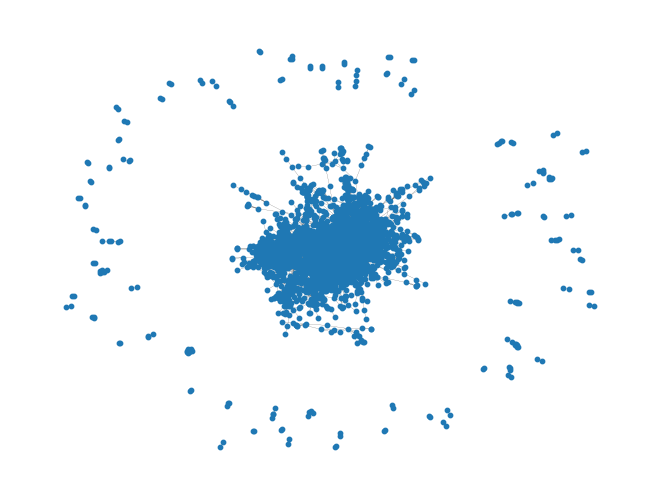

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
G.add_edges_from(data.edge_index.cpu().numpy().T)

options = {
    'node_size': 10,
    'width': 0.1,
}
nx.draw(G, with_labels=False, **options)
plt.show()


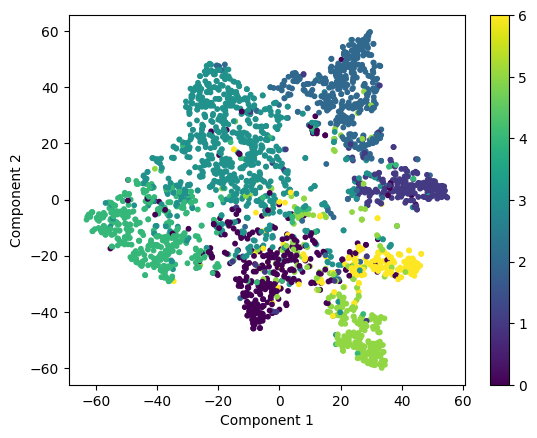

In [ ]:
def get_hidden_embeddings():
    model.eval()
    x, edge_index = data.x, data.edge_index
    x = model.conv1(x, edge_index)
    x = F.relu(x)
    return x.detach().cpu().numpy()

hidden_embeddings = get_hidden_embeddings()

# Use t-SNE or PCA for dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reduced_embeddings = TSNE(n_components=2).fit_transform(hidden_embeddings)
# or
# reduced_embeddings = PCA(n_components=2).fit_transform(hidden_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu(), cmap='viridis', s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()
